# Hike Planning


In [113]:
import numpy as np
import copy
import matplotlib.pyplot as plt

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer, Aer
# from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit_optimization.algorithms import (
    CplexOptimizer,
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
    WarmStartQAOAOptimizer
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.opflow import PauliExpectation, StateFn, CircuitSampler
from qiskit.circuit.library import QAOAAnsatz, RealAmplitudes
from qiskit.algorithms.optimizers import CG, SLSQP,L_BFGS_B, SPSA, COBYLA, QNSPSA
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile, schedule, QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import TemplateOptimization, RZXCalibrationBuilderNoEcho
from qiskit.circuit import Parameter, Instruction, Qubit
from qiskit.execute_function import execute
from qiskit.opflow.expectations import CVaRExpectation

In [2]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective += mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    mdl.minimize(objective)
#     cost = mdl.sum(x)
#     mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [3]:
# h = np.array([396, 752, 1204, 1177])
# d = np.array([1040, 2480, 7960, 3230])
# T = 5
# M = 1000.0

h = np.array([870, 2501, 4478, 1777, 2970])
d = np.array([2700, 6500, 15000, 100, 10000])
T = 13.5
M = 1000

t = h/(M/2.0) + d/(5.0*M)
print(t)
Q = np.outer(t, t)
print(Q)
b = -2.0 * T * t
# print(b)
# Q = Q + np.diag(b)
# print(Q)

[ 2.28   6.302 11.956  3.574  7.94 ]
[[  5.1984    14.36856   27.25968    8.14872   18.1032  ]
 [ 14.36856   39.715204  75.346712  22.523348  50.03788 ]
 [ 27.25968   75.346712 142.945936  42.730744  94.93064 ]
 [  8.14872   22.523348  42.730744  12.773476  28.37756 ]
 [ 18.1032    50.03788   94.93064   28.37756   63.0436  ]]


In [4]:
import itertools

values = []
print("x, cost")
for x in itertools.product([0, 1], repeat=t.size):
    values.append((x, (T-np.asarray(x).dot(t))**2))
    print(*values[-1])

optimal = min(values, key=lambda value: value[1])
print("Optimal solution:", *optimal)

x, cost
(0, 0, 0, 0, 0) 182.25
(0, 0, 0, 0, 1) 30.913599999999995
(0, 0, 0, 1, 0) 98.525476
(0, 0, 0, 1, 1) 3.9441960000000025
(0, 0, 1, 0, 0) 2.3839360000000016
(0, 0, 1, 0, 1) 40.90881600000001
(0, 0, 1, 1, 0) 4.120899999999997
(0, 0, 1, 1, 1) 99.40089999999998
(0, 1, 0, 0, 0) 51.811204000000004
(0, 1, 0, 0, 1) 0.5505640000000013
(0, 1, 0, 1, 0) 13.133376000000004
(0, 1, 0, 1, 1) 18.627856000000023
(0, 1, 1, 0, 0) 22.63856399999999
(0, 1, 1, 0, 1) 161.239204
(0, 1, 1, 1, 0) 69.42222400000001
(0, 1, 1, 1, 1) 264.77798399999995
(1, 0, 0, 0, 0) 125.88839999999998
(1, 0, 0, 0, 1) 10.758399999999996
(1, 0, 0, 1, 0) 58.461316
(1, 0, 0, 1, 1) 0.08643600000000029
(1, 0, 1, 0, 0) 0.541696000000001
(1, 0, 1, 0, 1) 75.27297600000003
(1, 0, 1, 1, 0) 18.57609999999999
(1, 0, 1, 1, 1) 150.0625
(1, 1, 0, 0, 0) 24.18672399999999
(1, 1, 0, 0, 1) 9.132483999999991
(1, 1, 0, 1, 0) 1.8063359999999984
(1, 1, 0, 1, 1) 43.50721599999996
(1, 1, 1, 0, 0) 49.533444
(1, 1, 1, 0, 1) 224.34048399999995
(1, 1, 1,

In [5]:
qubo = create_problem(b, Q)
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 61.560000000000 x0 - 170.154000000000 x1 - 322.812000000000 x2
      - 96.498000000000 x3 - 214.380000000000 x4 + [ 10.396800000000 x0^2
      + 57.474240000000 x0*x1 + 109.038720000000 x0*x2 + 32.594880000000 x0*x3
      + 72.412800000000 x0*x4 + 79.430408000000 x1^2 + 301.386848000000 x1*x2
      + 90.093392000000 x1*x3 + 200.151520000000 x1*x4 + 285.891872000000 x2^2
      + 170.922976000000 x2*x3 + 379.722560000000 x2*x4 + 25.546952000000 x3^2
      + 113.510240000000 x3*x4 + 126.087200000000 x4^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

## A. Constructing the Ising Hamiltonian

Math! No tips here.

In [6]:
H, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(H)

offset: -109.95016999999996
operator:
-5.759280000000004 * IIIIZ
- 15.918851999999994 * IIIZI
- 30.20085599999999 * IIZII
- 9.027923999999999 * IZIII
- 20.056439999999995 * ZIIII
+ 7.18428 * IIIZZ
+ 13.629840000000002 * IIZIZ
+ 37.673356 * IIZZI
+ 4.07436 * IZIIZ
+ 11.261674 * IZIZI
+ 21.365371999999997 * IZZII
+ 9.051600000000002 * ZIIIZ
+ 25.01894 * ZIIZI
+ 47.46532 * ZIZII
+ 14.18878 * ZZIII


In [7]:
exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
exact.eigenstate

VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)

In [8]:
statevector = exact.eigenstate.primitive
print("Optimal state from Hamiltonian:")
print(statevector.probabilities_dict())
print("Value:")
print(exact.eigenvalue+offset+T**2)

print("\nCompare to orignal solution:")
print(optimal)

Optimal state from Hamiltonian:
{'11001': 1.0}
Value:
(0.08643600000004881+0j)

Compare to orignal solution:
((1, 0, 0, 1, 1), 0.08643600000000029)


## B. Finding the minimum

### Evaluating the cost function

First, construct the QAOA ansatz and then write a function to evaluate the energy. Given a quantum circuit, you can evaluate the expectation value as

In [13]:
qaoa = QAOAAnsatz(H, reps=3)
def exact_energy(theta):
    bound = qaoa.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(H.primitive))

### Optimize the energy

Now optimize the energy. You could for instance use one of Qiskit's built-in optimizers as

In [14]:
optimizer = L_BFGS_B()
initial_parameters = np.random.random(qaoa.num_parameters)
result = optimizer.minimize(exact_energy, initial_parameters)

In [15]:
final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

<Figure size 700x500 with 1 Axes>

## Annealing Initialization
Initialize QAOA parameters $\beta,\gamma$ based on Trotterized Quantum Annealing Protocol.

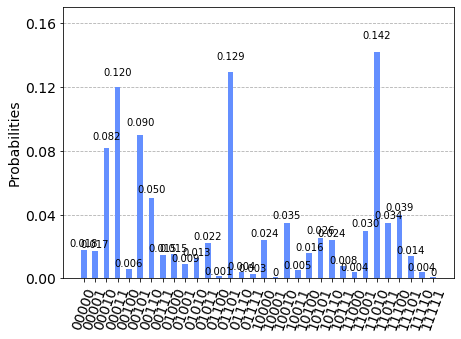

In [16]:
p = 3
delta_t = 0.5
qaoa = QAOAAnsatz(H, reps=p)
annealing_init = np.zeros(2*p)
for i in range(p):
    annealing_init[i] = (1-(i+1)/p) * delta_t
    annealing_init[i+p] = (i+1)/p * delta_t

optimizer = CG()
# optimizer = L_BFGS_B()
result = optimizer.minimize(exact_energy, annealing_init)
final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()
# print(probabilities['11001'])
plot_histogram(probabilities)

### Warmstarting
Initialize the state using solution from a classical Linear Programming solver. Note that relax_for_pre_solver is set to True, so we are only using an LP solver (LP is in P, but Integer LP is NP hard).

In [88]:
algorithm_globals.random_seed = 12345

quantum_instance = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)


qaoa_mes = QAOA(quantum_instance=quantum_instance,
                optimizer=SPSA(maxiter=3),
                reps=3,
               )
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.1
)
ws_result = ws_qaoa.solve(qubo)
ws_result

optimal function value: -182.16356399999998
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS

In [89]:
sol = CplexOptimizer().solve(qubo)
c_stars = sol.samples[0].x
c_stars

from qiskit import QuantumCircuit

thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(Q))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

from qiskit.circuit import Parameter

beta = Parameter("β")

ws_mixer = QuantumCircuit(len(Q))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)
ws_qaoa_result = ws_qaoa.solve(qubo)
print(ws_qaoa_result)

optimal function value: -182.16356399999998
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS


## Recursive QAOA
This is supposed to reduce circuit depth when working with a large amount of qubits. Because it will switch to different solver (probabily classical one) when the problem size is reduced to be classically solvable.

In [118]:
qaoa_mes = QAOA(quantum_instance=quantum_instance,
                reps=p,
                optimizer=SPSA(maxiter=3),
                initial_point=initial_parameters)
qaoa_opt = MinimumEigenOptimizer(qaoa_mes)   # using QAOA

rqaoa = RecursiveMinimumEigenOptimizer(optimizer=qaoa_opt, min_num_vars=1)
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)

optimal function value: -130.438796
optimal value: [0. 1. 0. 0. 0.]
status: SUCCESS


### CVaR expectation

Update your energy evaluation such that only the best $\alpha \in (0, 1]$ fraction of the shots contribute to the expectation value.

In [105]:
# set classical optimizer
maxiter = 600
#optimizer = CG()
optimizer = QNSPSA(QNSPSA.get_fidelity(qaoa), maxiter=maxiter)

# set variational ansatz
# ansatz = RealAmplitudes(n, reps=1)
ansatz = qaoa
m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated

# solve classically as reference
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qubo)
opt_result

optimal function value: -182.16356399999998
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS

In [106]:
print(offset)
print(T**2)

-109.95016999999996
182.25


In [111]:
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [obj + offset]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
    cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    vqe = VQE(
        expectation=None,
        optimizer=optimizer,
        ansatz=ansatz,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(vqe)

    # solve problem
    results[alpha] = opt_alg.solve(qubo)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha])
    print()

alpha = 1.0:
optimal function value: -181.70830400000003
optimal value: [1. 0. 1. 0. 0.]
status: SUCCESS

alpha = 0.5:
optimal function value: -182.16356399999998
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS

alpha = 0.25:
optimal function value: -182.16356399999998
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS



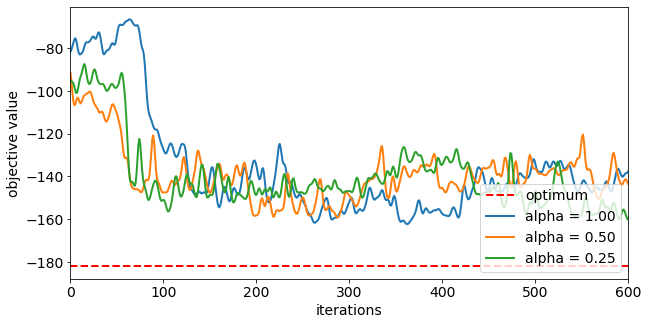

In [114]:
from scipy.ndimage.filters import gaussian_filter1d

# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    #plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
    plt.plot(gaussian_filter1d(objectives[alpha], sigma=2), label="alpha = %.2f" % alpha, linewidth=2)

plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [115]:
# evaluate final optimal probability for each alpha
probs = {}
for alpha in alphas:
    s = 0
    if backend_name == "qasm_simulator":
        counts = results[alpha].min_eigen_solver_result.eigenstate
        shots = sum(counts.values())
        for key, val in counts.items():
            probs[key] = val / shots
            s += probs[key]
    else:
        probabilities = np.abs(results[alpha].min_eigen_solver_result.eigenstate)**2
    print(s)

1.0
1.0
1.0


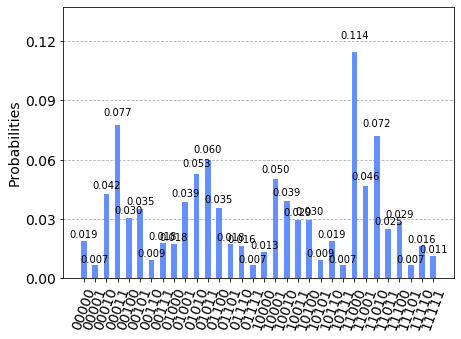

In [116]:
plot_histogram(probs)

# Real Amplitudes Ansatz

In [75]:
ra = RealAmplitudes(5, reps=3, entanglement='linear')
ra.decompose().draw()

┌──────────┐     ┌──────────┐                        ┌───────────┐»
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├─────────────────■──────┤ Ry(θ[10]) ├»
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐   ┌─┴─┐    └───────────┘»
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[6]) ├───┤ X ├──────────■──────»
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────┤ X ├────»
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘ ┌──┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├─────────■───────┤ Ry(θ[8]) ├»
     ├──────────┤                    └───┘       ┌─┴─┐     ├──────────┤»
q_4: ┤ Ry(θ[4]) ├────────────────────────────────┤ X ├─────┤ Ry(θ[9]) ├»
     └──────────┘                                └───┘     └──────────┘»
«                               ┌───────────┐                          »
«q_0: ───────────────────■──────┤ Ry(θ[15]) ├──────────────────────────»
«     ┌───────────┐    ┌─┴─┐    └───────────┘┌───────────┐             »
«q_1: ┤ Ry(θ[11]) ├────┤ X ├──────────■──────┤ Ry(θ[16]) ├─────────────»
«     └───────────┘┌───┴───┴───┐    ┌─┴─┐    └───────────┘┌───────────┐»
«q_2: ──────■──────┤ Ry(θ[12]) ├────┤ X ├──────────■──────┤ Ry(θ[17]) ├»
«         ┌─┴─┐    └───────────┘┌───┴───┴───┐    ┌─┴─┐    └───────────┘»
«q_3: ────┤ X ├──────────■──────┤ Ry(θ[13]) ├────┤ X ├──────────■──────»
«         └───┘        ┌─┴─┐    ├───────────┤    └───┘        ┌─┴─┐    »
«q_4: ─────────────────┤ X ├────┤ Ry(θ[14]) ├─────────────────┤ X ├────»
«                      └───┘    └───────────┘                 └───┘    »
«                  
«q_0: ─────────────
«                  
«q_1: ─────────────
«                  
«q_2: ─────────────
«     ┌───────────┐
«q_3: ┤ Ry(θ[18]) ├
«     ├───────────┤
«q_4: ┤ Ry(θ[19]) ├
«     └───────────┘

## C. Circuit optimization

Now we'll transpile the circuit for the ``ibmq_quito`` device.

In [17]:
from qiskit.test.mock import FakeQuito
backend = FakeQuito()

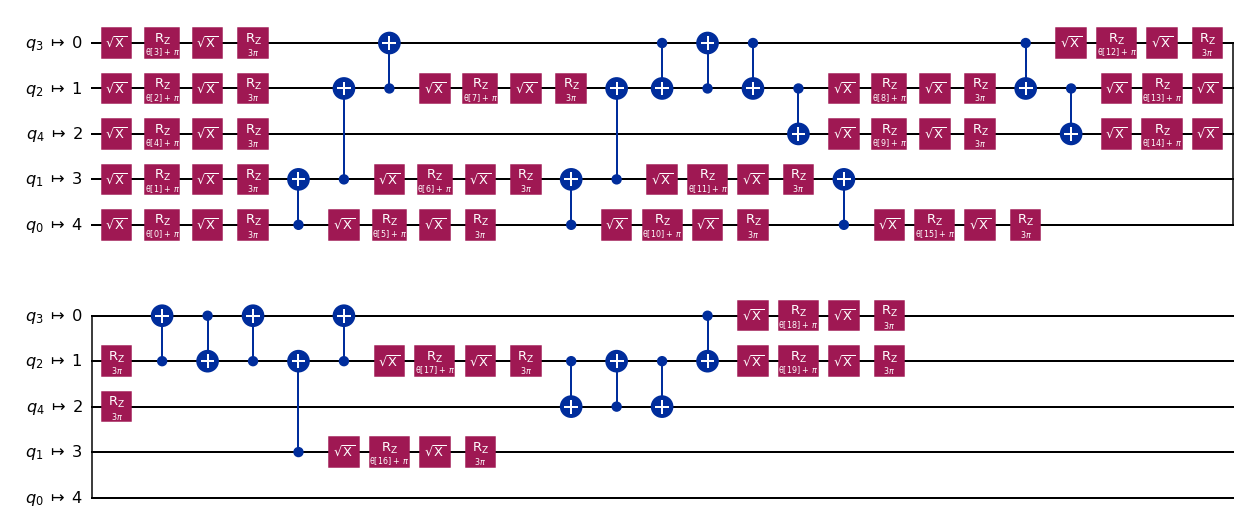

In [76]:
transpiled_ra = ra.decompose().decompose().decompose()
transpile(transpiled_ra, backend, optimization_level=3).draw("mpl", style="iqx")

In [78]:
transpiled_ra.count_ops()

OrderedDict([('u3', 20), ('cx', 12)])

In [82]:
def exact_energy_ra(theta):
    bound = ra.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(H.primitive))

optimizer = SLSQP()

initial_parameters = np.random.random(ra.num_parameters)
result_ra = optimizer.minimize(exact_energy_ra, initial_parameters)
print(result_ra.nfev)

1080


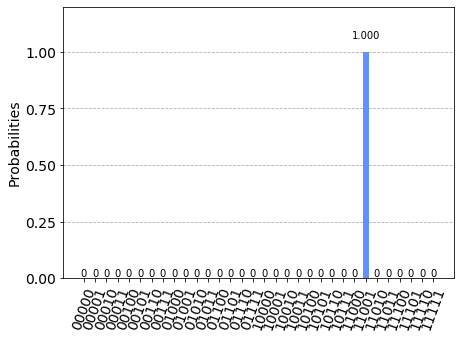

In [84]:
final_state = Statevector(ra.bind_parameters(result_ra.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

## Transpile QAOA circuits.

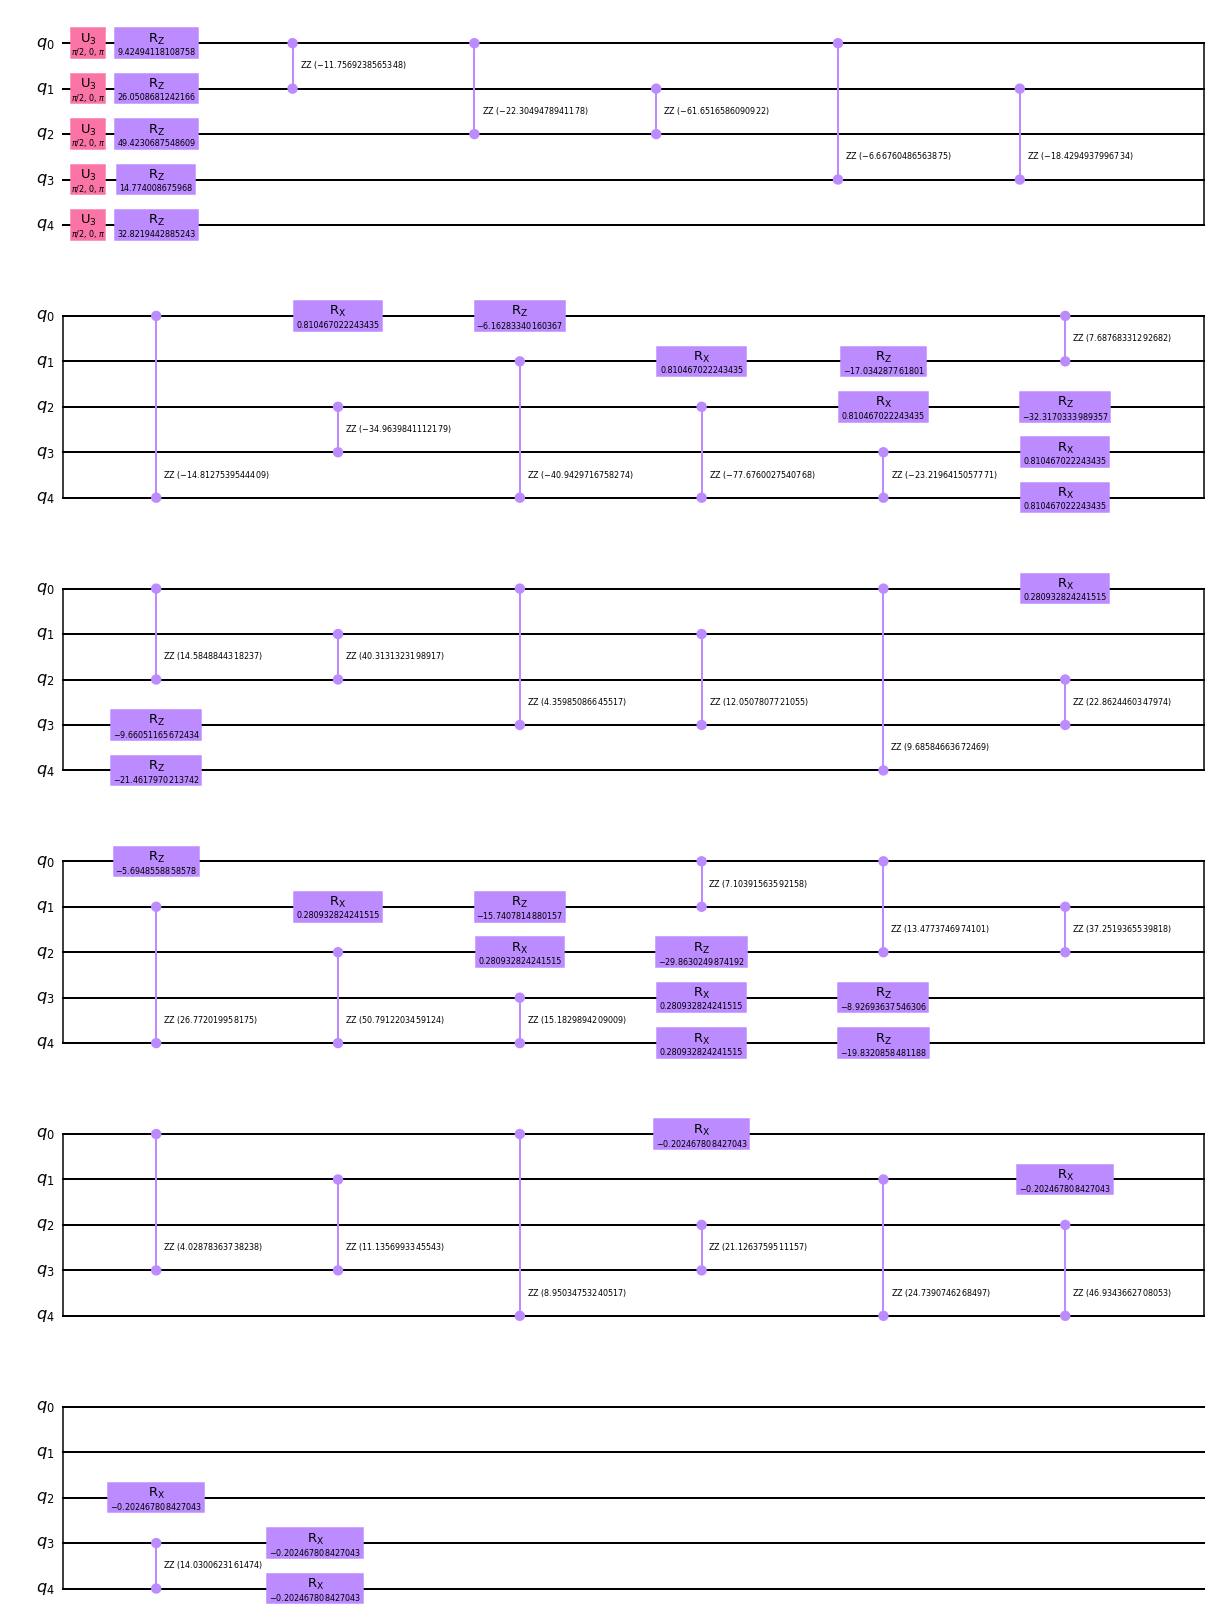

In [18]:
circuit = qaoa.bind_parameters(result.x)
circuit = circuit.decompose().decompose().decompose()
circuit.draw(output='mpl')

In [19]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

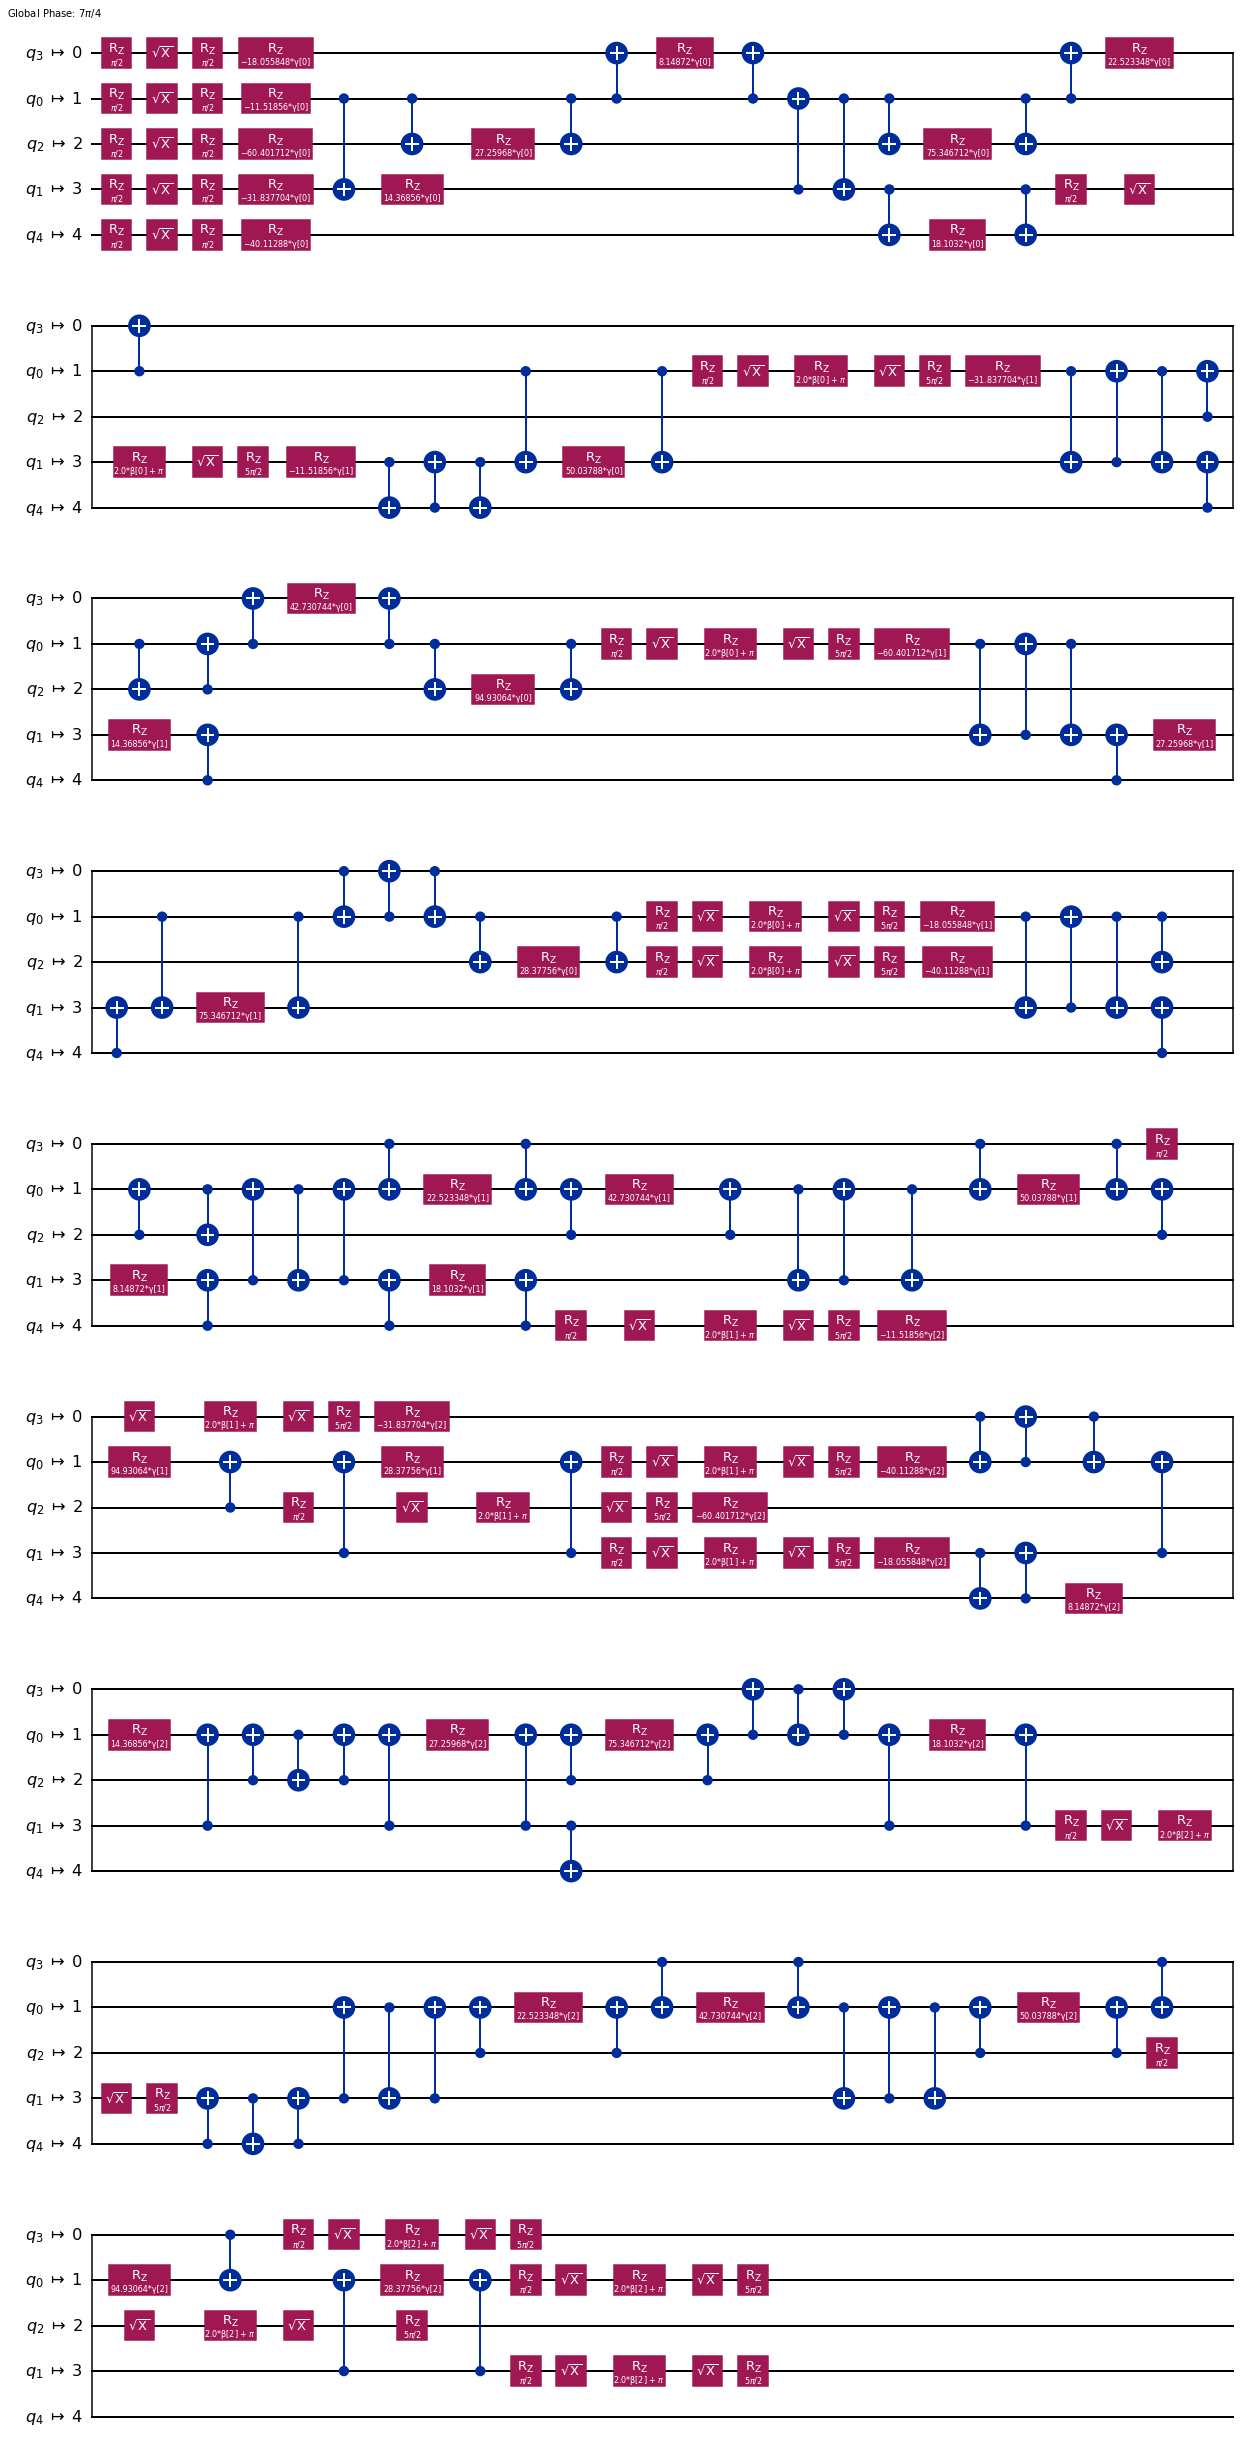

In [30]:
transpiled = transpile(qaoa, backend, optimization_level=3)
transpiled.draw("mpl", style="iqx")

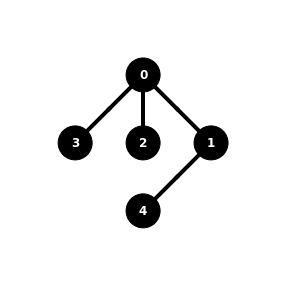

In [31]:
plot_circuit_layout(transpiled, backend)

In [32]:
transpiled.count_ops()

OrderedDict([('cx', 107), ('rz', 100), ('sx', 35)])

In [33]:
cx_fidelity = 1 - 1.12e-2
num_cx = transpiled.count_ops()["cx"]
total_cx_fidelity = cx_fidelity ** num_cx

print(f"Estimated fidelity after {num_cx} CX:", total_cx_fidelity)

Estimated fidelity after 107 CX: 0.2996435810431322


### Pulse efficient decomposition

*Note: This works correctly only for a circuit with bound parameters.*

You can draw a pulse schedule as follows.

In [34]:
schedule(transpiled.bind_parameters(result.x), backend).duration

158080

Tranpiler passes and pass manager: https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html 

In [65]:
from qiskit.extensions import UnitaryGate
def U_theta(theta):
    arr = np.array([[np.exp(-1j*theta),0,0,0],
                    [0,0,np.exp(1j*theta), 0],
                    [0,np.exp(1j*theta),0,0],
                    [0,0,0,np.exp(-1j*theta)]])
#     arr = np.array([[1,0,0,0],
#                     [0,0,np.cos(theta)+1j*np.sin(theta), 0],
#                     [0,np.cos(theta)+1j*np.sin(theta),0,0],
#                     [0,0,0,1]])
    u_gate = UnitaryGate(data = arr,label = 'phase_swap')
    return u_gate


In [36]:
def create_t1(theta):
    t1 = QuantumCircuit(2)
    t1.cx(0,1)
    t1.rz(theta, 1)
    t1.cx(0,1)
    t1.rzz(-theta, 0, 1)
#     t1.draw(output='mpl')
    return t1

def create_t2(theta):
    # induce a global phase of np.exp(-1j*theta/2)
    t2 = QuantumCircuit(2)
    t2.cx(0,1)
    t2.rz(theta,1)
    t2.cx(0,1)
    t2.swap(0,1)
    t2.append(U_theta(-theta/2.0), [0,1])
#     t2.draw(output='mpl')
    return t2

In [69]:
theta = 2.12
t2 = QuantumCircuit(2)
t2.cx(0,1)
t2.rz(theta,1)
t2.cx(0,1)
t2.swap(0,1)
t2.append(U_theta(-theta/2.0), [0,1])
t2.draw()
simulator0 = Aer.get_backend('unitary_simulator')
result = execute(t2, backend=simulator0).result()
print(result.get_unitary(0))

Operator([[ 1.+7.51703826e-18j, -0.+0.00000000e+00j, -0.+0.00000000e+00j,
            0.+0.00000000e+00j],
          [-0.+0.00000000e+00j,  1.-7.51703826e-18j, -0.+0.00000000e+00j,
            0.+0.00000000e+00j],
          [-0.+0.00000000e+00j, -0.+0.00000000e+00j,  1.-7.51703826e-18j,
            0.+0.00000000e+00j],
          [-0.+0.00000000e+00j, -0.+0.00000000e+00j, -0.+0.00000000e+00j,
            1.+7.51703826e-18j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [71]:
# print(circuit.data)
circ_params = []
for d in circuit.data:
    if isinstance(d[0], Instruction) and d[0].name == 'rz':
        circ_params.append(d[0].params[0])
print(circ_params)
cost_dict = {'sx':1, 'x':1, 'rz':0, 'cx':2, 'rzz':0, 'swap':6, 'phase_swap':0}
# # 1. Template substitution: inntroduces custom gates with an rzx decomposition
pass_ = TemplateOptimization(template_list=[create_t1(t) for t in circ_params], user_cost_dict=cost_dict)
qct = PassManager(pass_).run(circuit)

[ParameterExpression(9.42494118108758), ParameterExpression(26.0508681242166), ParameterExpression(49.4230687548609), ParameterExpression(14.774008675968), ParameterExpression(32.8219442885243), ParameterExpression(-6.16283340160367), ParameterExpression(-17.034287761801), ParameterExpression(-32.3170333989357), ParameterExpression(-9.66051165672434), ParameterExpression(-21.4617970213742), ParameterExpression(-5.6948558858578), ParameterExpression(-15.7407814880157), ParameterExpression(-29.8630249874192), ParameterExpression(-8.92693637546306), ParameterExpression(-19.8320858481188)]


In [72]:
qct_rzx = transpile(qct, backend, optimization_level=3)
pass_ = RZXCalibrationBuilderNoEcho(backend)
cal_qc = PassManager(pass_).run(qct_rzx)

In [73]:
schedule(qct_rzx, backend).duration

148544